In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.layers import Dropout
from sklearn.manifold import TSNE
np.random.seed(8)
import matplotlib.pyplot as plt
from ggplot import *
from keras.callbacks import Callback
import seaborn as sns
import theano
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from keras import backend as K

Using Theano backend.
/Users/jieyichen/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [2]:
yeast = pd.read_table('yeast.data.txt', delim_whitespace = True, index_col= False, header = None, names = ('Sequence Name', 'mcg', 'gvh', 'alm', 'mit',
                                                                 'erl', 'pox', 'vac', 'nuc', 'category'))

### Problem 1

The dataset is very imbalance in terms of number of observations per category. For example, there are only 5 observations for Category ERL. n_neighbors = 20 is the recommended value, however, the number of neighbors should not be greater than the samples. Therefore, we will do LocalOutlierFactor for each class to increase its accuracy. We see a similar situation in the isolation forest detection method. We modified the num_max_sample to get a better performance.

In [3]:
def outlier_detection_local(yeast, var_cat, n_neighbors_local):
    """
    use LOF to detect outliers
    
    parameters: pass in the yeast dataframe, category name, num of neighbors
    
    return dataframe without outliers
    """
    dataframe = yeast.loc[yeast['category'] == var_cat]
    feature_df = dataframe.drop(['Sequence Name', 'category'], axis = 1).reset_index(drop = True)
    if var_cat == 'ERL':
        clf_local = LocalOutlierFactor(n_neighbors=4, contamination=0.1)
    else:
        clf_local = LocalOutlierFactor(n_neighbors_local, contamination=0.1)
    y_pred_local = clf_local.fit_predict(feature_df)
    output_df_local = feature_df.loc[np.where(y_pred_local == 1)[0].tolist()].reset_index(drop = True)
    output_df_local['category'] = var_cat
    return output_df_local

In [4]:
var_cat_list = list(yeast.category.unique())

In [5]:
df_no_outlier_local = pd.DataFrame()
for var_cat in var_cat_list:
    df_no_outlier_local = df_no_outlier_local.append(outlier_detection_local(yeast, var_cat, 20))

In [6]:
df_no_outlier_local.shape

(1332, 9)

In [7]:
def outlier_detection_iso(yeast, var_cat, num_max_samples):
    """
    use isolation forest to detect outliers
    
    parameters: pass in the yeast dataframe, category name, num of neighbors
    
    return dataframe without outliers
    """
    dataframe = yeast.loc[yeast['category'] == var_cat]
    feature_df = dataframe.drop(['Sequence Name', 'category'], axis = 1).reset_index(drop = True)
    
    # IsolationForest
    if sum(yeast['category'] == var_cat) > 150:
        clf_iso = IsolationForest(behaviour='new', max_samples = num_max_samples, contamination='auto')
    else:
        clf_iso = IsolationForest(behaviour='new', max_samples = (sum(yeast['category'] == var_cat) - 3), contamination='auto')
    y_pred_iso = clf_iso.fit_predict(feature_df)
    output_df_iso = feature_df.loc[np.where(y_pred_iso == 1)[0].tolist()].reset_index(drop = True)
    output_df_iso['category'] = var_cat
    return output_df_iso

In [8]:
output_iso_df = pd.DataFrame()
for var_cat in var_cat_list:
    output_iso_df = output_iso_df.append(outlier_detection_iso(yeast, var_cat, 100))

In [9]:
output_iso_df.shape

(1345, 9)

In [10]:
def graph_plot(dataframe):
    """
    plot tsne graph to check the outlier detection method's performance
    """
    X_matrix = dataframe.loc[:, 'mcg': 'nuc'].values.astype(np.float32)
    X_tsne = TSNE(learning_rate=100).fit_transform(X_matrix)
    dataframe['x-tsne'] = X_tsne[:, 0]
    dataframe['y-tsne'] = X_tsne[:, 1]
    return ggplot(dataframe, aes(x='x-tsne', y='y-tsne', color = 'category', shape = 'category')) + geom_point(size=70) + ggtitle("tSNE dimensions colored by category")



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

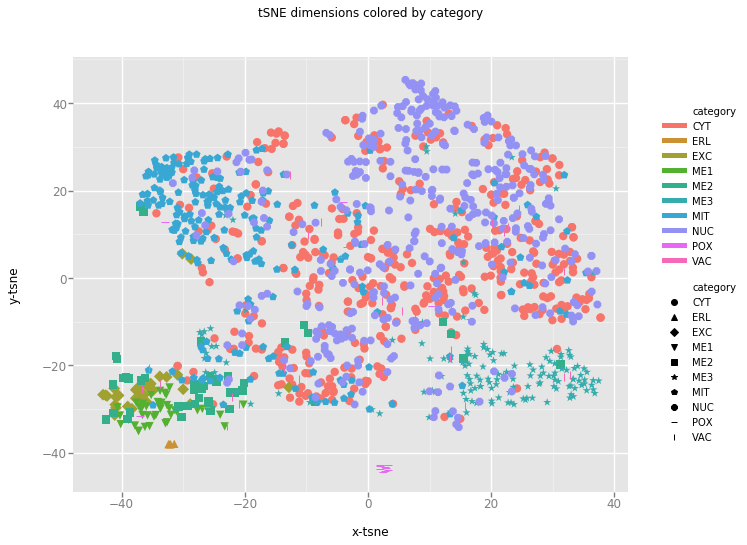

<ggplot: (-9223372036548121214)>

In [11]:
graph_plot(df_no_outlier_local)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

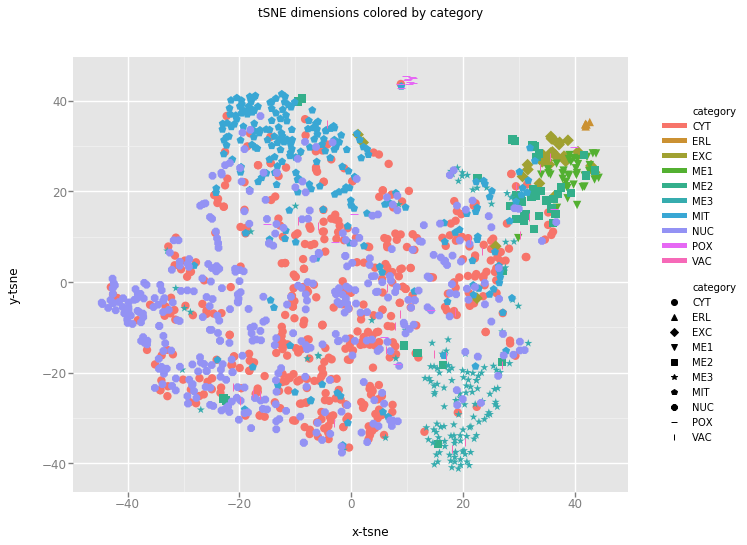

<ggplot: (-9223372036546713421)>

In [12]:
graph_plot(output_iso_df)

(a) Yes, there are outliers on the dataset.

(b) Both methods agree that the dataset contains outliers. However, LocalOutlierFactor removes more outliers than Isolation Forest. 

(c) LocalOutlierFactor relies on the assumption that normal data are more concentrated in a certain region while outliers locate in a sparse region. 

Isolation forest relies on the assumption that an outlier is easier to isolate by lines than normal data.

(d) Remove outliers using Isolation Forest.

### Problem 2

In [13]:
# Use isolation Forest Method to remove outliers
modified_df = output_iso_df.drop(['x-tsne', 'y-tsne'], axis = 1)

In [14]:
def encode_df(dataframe):
    # encode category variable into indexes
    pre_process = preprocessing.LabelEncoder()
    dataframe['num_category'] = pre_process.fit_transform(dataframe['category'])
    cat_matches = dataframe[['category', 'num_category']].drop_duplicates()
    category = pre_process.classes_

    X_matrix = dataframe.loc[:, 'mcg': 'nuc'].values.astype(np.float32)
    dum_var = pd.get_dummies(dataframe['num_category'])
    Y_matrix = dum_var.values.astype(np.float32)
    return X_matrix, Y_matrix, category

In [15]:
X_matrix, Y_matrix, category = encode_df(modified_df)

In [16]:
model = Sequential()
# input_dim = # of features
# Hidden Layer 1
model.add(Dense(3, input_dim = X_matrix.shape[1], activation = 'sigmoid'))
# Hidden Layer 2
model.add(Dense(3, activation = 'sigmoid'))
# Output Layer
# input_dim = # of output
model.add(Dense(Y_matrix.shape[1], activation = 'softmax'))
# Compile model
sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])

In [17]:
class weightHistory(Callback):
    def __init__(self, x_matrix):
        self.data = x_matrix
        
    def on_train_begin(self, logs = {}):
        ## called at the beginning of the model training
        # initialize empty list for epoches and weights and an empty dictionary for history
        self.epoch = []
        self.weights = []
        self.predictions = []
        self.weights.append(self.model.weights)
        
    def on_epoch_end(self, epoch, logs = {}):
        ## called at the end of model training
        self.epoch.append(epoch)
        pred = model.predict(x_matrix)
        self.predictions.append(pred)
        self.weights.append(self.model.get_weights())

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_matrix, Y_matrix, test_size = 0.3, random_state = 42)

In [19]:
# create a callback for weight_prediction_history
x_matrix = X_train
model_history = weightHistory(X_train)

In [20]:
# batch_size = 1 because it is the stochastic gradient descent
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), callbacks = [model_history], epochs = 150, batch_size = 1, verbose = 0)


In [21]:
# extract the weights for CYT only
final_df = pd.DataFrame()
weight_list = []
for item in model_history.weights[1:]:
    for weight in item[4]:
        weight_list.append(weight[0])
    weight_list.append(item[5][0])

In [22]:
final_list = np.array(weight_list)

In [23]:
final_array = np.split(final_list, len(model_history.weights[1:]))

In [211]:
weight_df = pd.DataFrame(final_array, columns = ['weight_1', 'weight_2', 'weight_3', 'bias'])
weight_df['epoch'] = np.arange(1, len(weight_df)+1)

In [235]:
weight_df

,weight_1,weight_2,weight_3,bias,epoch
0,0.353634,0.600798,0.984985,0.623535,1
1,0.394883,0.635944,1.038050,0.705661,2
2,0.415105,0.653665,1.067408,0.750636,3
3,0.412799,0.651675,1.070347,0.757764,4
4,0.416524,0.655415,1.080918,0.774658,5
5,0.392252,0.634828,1.058503,0.745838,6
6,0.414315,0.654257,1.090312,0.792141,7
7,0.461452,0.695723,1.151628,0.879118,8
8,0.442725,0.680453,1.136313,0.859473,9
9,0.411851,0.655191,1.107312,0.819295,10


Text(0.5, 1.0, 'Weights and bias plot for CYT')

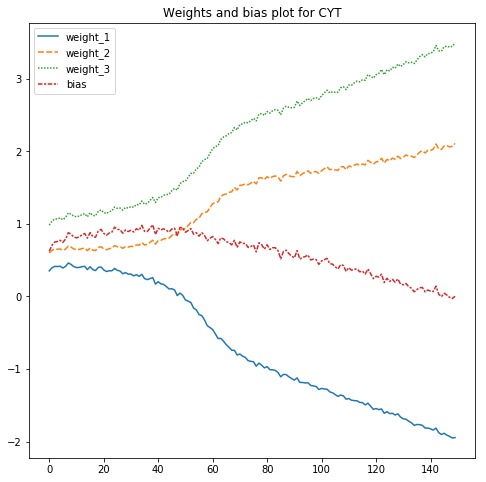

In [246]:
plt.rcParams['figure.figsize'] = [8, 8]
sns.lineplot(data = weight_df.iloc[:, 0:4]).set_title('Weights and bias plot for CYT')

In [28]:
# error = 1 - accuracy
error_list = [1 - var for var in history.history['acc']]
val_error_list = [1 - var for var in history.history['val_acc']]

In [29]:
def accuracy_plot(error_list, val_error_list):
    plt.plot(error_list)
    plt.plot(val_error_list)
    plt.title('Model Error')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    

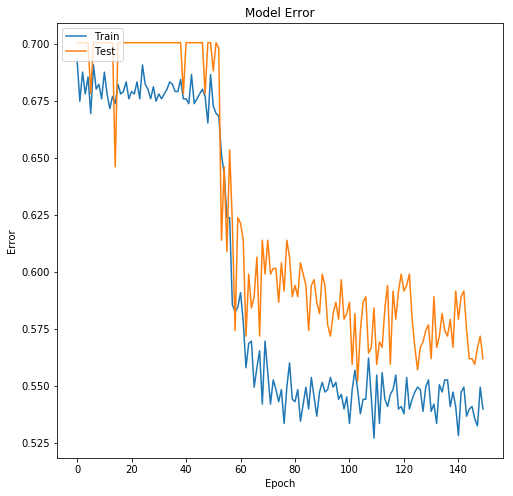

In [247]:
accuracy_plot(error_list, val_error_list)

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
# Plot training & validation loss values

def loss_plot(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

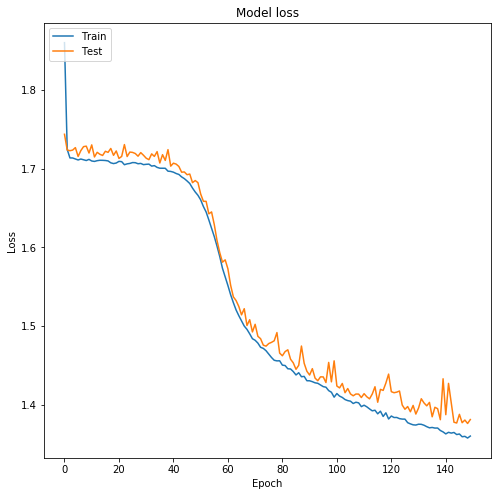

In [248]:
loss_plot(loss, val_loss)

### Problem 3

In [34]:
X_matrix_all, Y_matrix_all, category = encode_df(yeast)

In [35]:
history_all = model.fit(X_matrix_all, Y_matrix_all, callbacks = [model_history], epochs = 150, batch_size = 1, verbose = 0)


In [36]:
training_error_list = [1 - var for var in history_all.history['acc']]

In [37]:
error_df = pd.DataFrame(training_error_list, columns = ['training_error'])

In [38]:
error_df['epoch'] = np.arange(1, len(error_df)+1)

In [39]:
error_df = error_df[['epoch', 'training_error']]

In [40]:
# Problem 3 error df
error_df

,epoch,training_error
0,1,0.551887
1,2,0.568059
2,3,0.560647
3,4,0.549191
4,5,0.553235
5,6,0.559973
6,7,0.567385
7,8,0.558625
8,9,0.550539
9,10,0.565364


### Problem 4

In [41]:
# Backpropogation
model_back = Sequential()
# input_dim = # of features
# Hidden Layer 1
model_back.add(Dense(3, input_dim = X_matrix.shape[1], activation = 'sigmoid', kernel_initializer = 'zeros', bias_initializer= 'ones'))
model_back.layers[0].get_weights()

[array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32), array([1., 1., 1.], dtype=float32)]

In [42]:
# Hidden Layer 2
model_back.add(Dense(3, activation = 'sigmoid', bias_initializer= 'ones'))
model_back.layers[1].get_weights()


[array([[ 0.2885157 ,  0.15007329, -0.2697848 ],
        [-0.84490645,  0.51890874, -0.47144252],
        [-0.33753812,  0.9407184 ,  0.54724324]], dtype=float32),
 array([1., 1., 1.], dtype=float32)]

In [43]:
# Output Layer
# input_dim = # of output
model_back.add(Dense(Y_matrix.shape[1], activation = 'softmax', bias_initializer= 'ones'))
model_back.layers[2].get_weights()

[array([[ 0.5371748 , -0.26527536,  0.08623469, -0.29283202, -0.5771761 ,
          0.0364961 , -0.15968442, -0.19208124,  0.54288864,  0.59075224],
        [ 0.03545719, -0.0664953 , -0.4742814 , -0.03014451, -0.1657862 ,
         -0.03368115, -0.05236948, -0.03004026, -0.2806594 , -0.29026085],
        [-0.58669925,  0.33548915, -0.47667387, -0.6716246 ,  0.4851929 ,
         -0.05356944, -0.23507911,  0.22114581, -0.46402645, -0.40377453]],
       dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)]

In [224]:
# Compile model
sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
model_back.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])

model_history = weightHistory(X_train)
weight_initialized = model_back.get_weights()

# fit on the first sample in the training set
history_back = model_back.fit(X_train[0].reshape(1, -1), Y_train[0].reshape(1, -1), callbacks = [model_history], epochs = 2, batch_size = 1, verbose = 0)



In [45]:
output_layer = model_back.layers[0].output 
output_fn = theano.function([model_back.layers[0].input], output_layer)
layer_1 = output_fn(X_train[0].reshape(1, -1))
output_layer = model_back.layers[1].output 
output_fn = theano.function([model_back.layers[1].input], output_layer)
layer_2 = output_fn(layer_1)
output_layer = model_back.layers[2].output 
output_fn = theano.function([model_back.layers[2].input], output_layer)
layer_3 = output_fn(layer_2)

In [46]:
# output
layer_1

array([[0.73099977, 0.7310842 , 0.73117375]], dtype=float32)

In [47]:
# output
layer_2

array([[0.5850712, 0.8981969, 0.7030989]], dtype=float32)

In [89]:
# output
layer_3

array([[0.11438229, 0.12475157, 0.06022668, 0.06268091, 0.10573442,
        0.11665708, 0.0901494 , 0.13088317, 0.09428091, 0.10025359]],
      dtype=float32)

In [174]:
def layer_activation(num_layer_1, num_layer_2, layer):
    # combine weights and bais together
    x_input_weight = np.vstack((weight_initialized[num_layer_1], weight_initialized[num_layer_2]))
    x_list = [element for sublist in layer.tolist() for element in sublist]
    x_list.append(1)
    x_input_array = np.asarray(x_list)
    final = np.dot(x_input_weight.T, x_input_array)
    return final

In [175]:
# Z1^(3)
layer_activation(4, 5, layer_2)

array([0.93362547, 1.02095121, 0.28930649, 0.3293782 , 0.85454082,
       0.9534359 , 0.69425128, 1.0161241 , 0.73928463, 0.80102731])

In [189]:
# Z3^(2)
layer_activation(2, 3, layer_1)[2]

0.8582530690265031

### Problem 5

In [190]:
def nn_model_zero(num_layers, num_node):
    model = Sequential()
    # input_dim = # of features
    # Hidden Layer 1
    for num in range(num_layers):
        model.add(Dense(num_node, input_dim = X_matrix.shape[1], activation = 'sigmoid'))
    # Output Layer
    # input_dim = # of output
    model.add(Dense(Y_train.shape[1], activation = 'softmax'))
    # Compile model
    sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
    return model

In [191]:
num_layers_input = [1, 2, 3]

In [192]:
num_node_input = [3,6,9,12]

In [193]:
# Create hyperparameter options
hyperparameters = dict(num_layers = num_layers_input, num_node = num_node_input)

In [194]:
my_classifier = KerasClassifier(build_fn = nn_model_zero, verbose=0, epochs = 50)

In [195]:
grid = RandomizedSearchCV(estimator = my_classifier, param_distributions = hyperparameters, cv = 5, verbose = 1, n_iter = 12)

In [196]:
grid_result = grid.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.5min finished
/Users/jieyichen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [197]:
grid_result.best_params_

{'num_node': 9, 'num_layers': 1}

In [198]:
# The best scores
grid_result.best_score_

0.5823591936787434

In [199]:
# Errors = 1 - accuracy
error_best = 1 - grid_result.best_score_

In [200]:
print(error_best)

0.41764080632125655


In [202]:
final_list = []
accuracy_list = grid_result.cv_results_['mean_test_score']
params_list = grid_result.cv_results_['params']
for accuracy, param in zip(accuracy_list, params_list):
    final_list.append(param)
    ## calculate the error
    final_list.append(1 - accuracy)
    

In [203]:
np.array(final_list)

array([{'num_node': 3, 'num_layers': 1}, 0.4282677985339819,
       {'num_node': 6, 'num_layers': 1}, 0.4357066949103008,
       {'num_node': 9, 'num_layers': 1}, 0.41764080632125655,
       {'num_node': 12, 'num_layers': 1}, 0.43676939422975314,
       {'num_node': 3, 'num_layers': 2}, 0.5504782158054023,
       {'num_node': 6, 'num_layers': 2}, 0.4537725828975977,
       {'num_node': 9, 'num_layers': 2}, 0.49096705543627517,
       {'num_node': 12, 'num_layers': 2}, 0.4335812968731433,
       {'num_node': 3, 'num_layers': 3}, 0.5844845914942045,
       {'num_node': 6, 'num_layers': 3}, 0.5143464387539975,
       {'num_node': 9, 'num_layers': 3}, 0.4962805518118405,
       {'num_node': 12, 'num_layers': 3}, 0.5696068014652645],
      dtype=object)

In [204]:
predictions = grid.predict(X_test)

In [205]:
Y_matrix_classify = np.argmax(Y_test, axis = 1)

In [206]:
print (classification_report(Y_matrix_classify, predictions))

              precision    recall  f1-score   support

           0       0.43      0.84      0.57       121
           2       0.73      0.80      0.76        10
           3       0.55      0.67      0.60         9
           4       0.44      0.25      0.32        16
           5       0.92      0.73      0.81        45
           6       0.59      0.72      0.65        58
           7       0.85      0.17      0.28       130
           8       0.80      0.57      0.67         7
           9       0.00      0.00      0.00         8

   micro avg       0.55      0.55      0.55       404
   macro avg       0.59      0.53      0.52       404
weighted avg       0.65      0.55      0.50       404



/Users/jieyichen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jieyichen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jieyichen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Problem 6

In [207]:
# Predict
sample = np.array([[0.52,0.47,0.52,0.23,0.55,0.03,0.52,0.39]])

In [208]:
pred = np.argmax(model.predict(sample))

In [209]:
category[pred]

'NUC'